##Project for Digital Image Processing class  
  
Krzysztof Miśków

### Imports

In [3]:
import cv2
import matplotlib.pyplot as plt

In [14]:
def plot_image(image, title='Image'):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
template_image = cv2.imread('template.jpg')

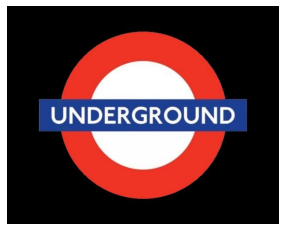

In [3]:
image_rgb = cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  
plt.show()


Text(0, 0.5, 'Frequency')

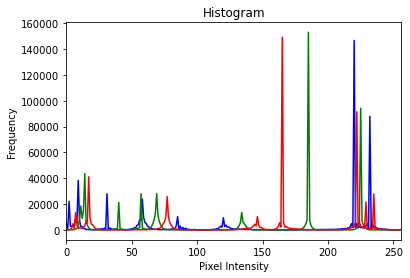

In [7]:
# Histogram
colors = ('b', 'g', 'r')
for i, color in enumerate(colors):
    histogram = cv2.calcHist([template_image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color)
    plt.xlim([0, 256])
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

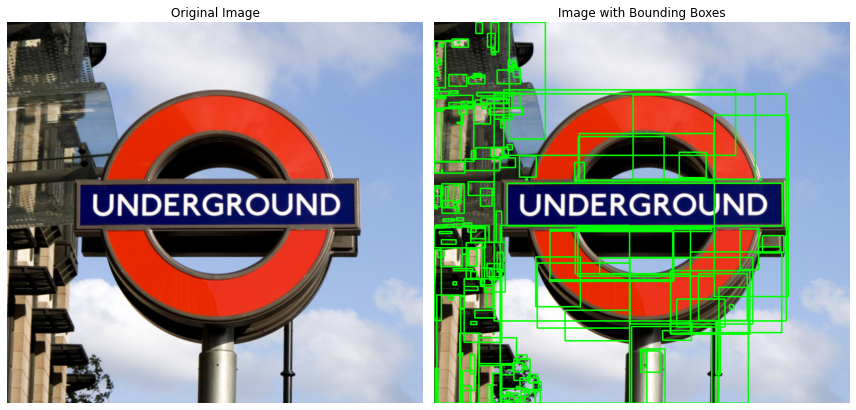

In [10]:
image = cv2.imread('test_image_1.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred_image, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on the original image
image_with_boxes = image.copy()
for contour in contours:
    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)
    # Draw the bounding box
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the original image and the image with bounding boxes using matplotlib
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Original Image')

# Image with bounding boxes
plt.subplot(1, 2, 2)
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
plt.imshow(image_with_boxes_rgb)
plt.axis('off')
plt.title('Image with Bounding Boxes')

plt.tight_layout()
plt.show()

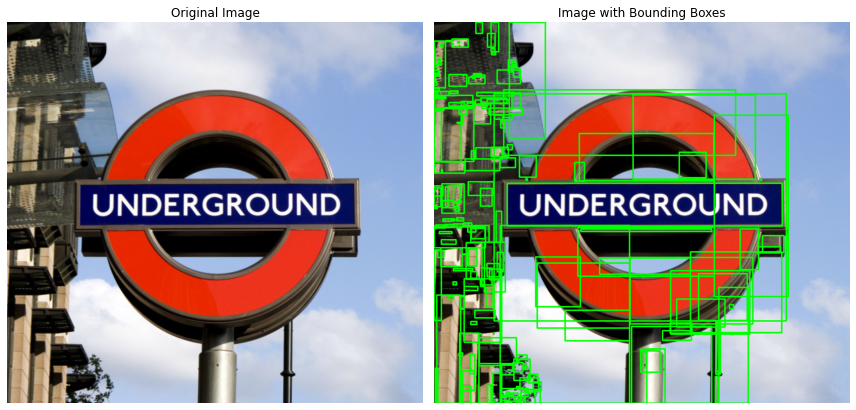

In [17]:
def calculate_iou(box1, box2):
    # Calculate the intersection area
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[0] + box1[2], box2[0] + box2[2])
    y2_inter = min(box1[1] + box1[3], box2[1] + box2[3])

    if x1_inter < x2_inter and y1_inter < y2_inter:
        inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        inter_area = 0

    # Calculate the union area
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

# Load an image from a file
image = cv2.imread('test_image_1.jpg')

# Check if the image was loaded successfully
if image is None:
    print("Error: Could not load image.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to the grayscale image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Use Canny edge detection
    edges = cv2.Canny(blurred_image, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get bounding boxes
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    # Filter out overlapping bounding boxes
    final_boxes = []
    for box in bounding_boxes:
        keep = True
        for other_box in final_boxes:
            iou = calculate_iou(box, other_box)
            if iou > 0.5:  # If boxes overlap significantly
                if box[2] * box[3] > other_box[2] * other_box[3]:
                    final_boxes.remove(other_box)
                else:
                    keep = False
                    break
        if keep:
            final_boxes.append(box)
    
    # Draw bounding boxes on the original image
    image_with_boxes = image.copy()
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display the original image and the image with bounding boxes using matplotlib
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Original Image')

    # Image with bounding boxes
    plt.subplot(1, 2, 2)
    image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    plt.imshow(image_with_boxes_rgb)
    plt.axis('off')
    plt.title('Image with Bounding Boxes')
    
    plt.tight_layout()
    plt.show()

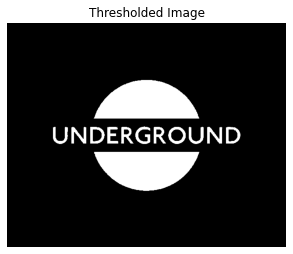

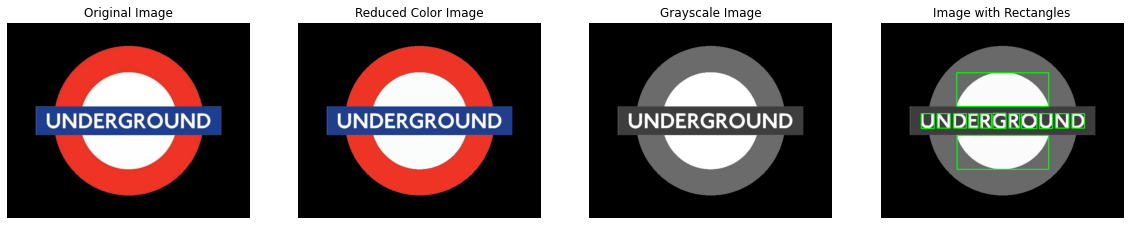

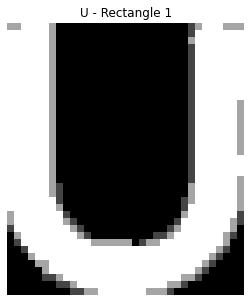

Hu Moments for U - Rectangle 1:
[ 5.84603582e-01  1.92790759e-03  2.16950328e-02  8.58943041e-03
 -1.17247942e-04 -3.34971789e-04  1.16604704e-06]


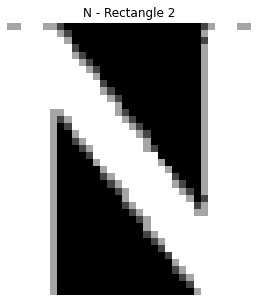

Hu Moments for N - Rectangle 2:
[ 4.26902104e-01  1.10498813e-02  1.61320157e-06  2.36718289e-07
 -1.16594277e-13  1.20535499e-08 -8.83420132e-14]


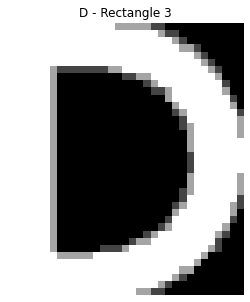

Hu Moments for D - Rectangle 3:
[ 1.66389620e-01  6.72843764e-04  3.45259469e-04  8.01678057e-06
 -4.20581831e-10 -2.07944176e-07  3.15988565e-11]


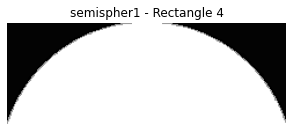

Hu Moments for semispher1 - Rectangle 4:
[ 2.45545213e-01  3.10824286e-02  2.03408498e-03  1.60835657e-04
 -9.19934784e-08 -2.83556111e-05  1.98812905e-10]


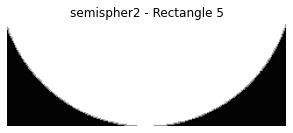

Hu Moments for semispher2 - Rectangle 5:
[ 2.44898300e-01  3.07662553e-02  2.02839551e-03  1.59868846e-04
 -9.10372187e-08 -2.80413892e-05  3.43933313e-10]


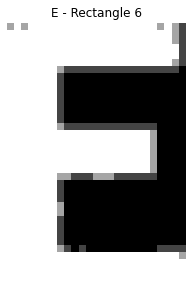

Hu Moments for E - Rectangle 6:
[ 4.23443060e-01  5.55877233e-02  4.10257113e-03  1.82936772e-03
 -4.01323897e-06 -4.08042405e-04  3.00173532e-06]


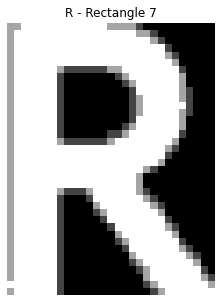

Hu Moments for R - Rectangle 7:
[ 2.39399927e-01  8.03669977e-03  8.07820359e-05  1.35359837e-03
 -7.49614447e-08  1.19489999e-04 -4.41280452e-07]


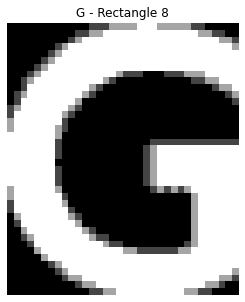

Hu Moments for G - Rectangle 8:
[ 4.86510687e-01  6.69408493e-03  5.40344542e-03  6.18994538e-04
 -3.52087489e-07 -3.85066769e-05 -1.07590502e-06]


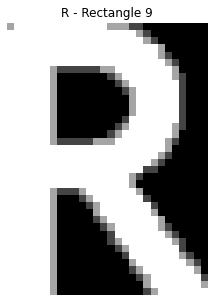

Hu Moments for R - Rectangle 9:
[ 2.37173439e-01  7.16928321e-03  7.74325037e-05  1.35129513e-03
 -4.63634942e-08  1.12901501e-04 -4.34640380e-07]


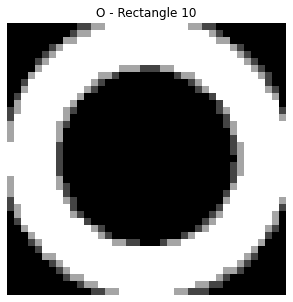

Hu Moments for O - Rectangle 10:
[1.59270302e-01 1.16160355e-05 7.09637081e-08 2.65123989e-11
 1.05960074e-20 7.31255241e-14 3.47877445e-20]


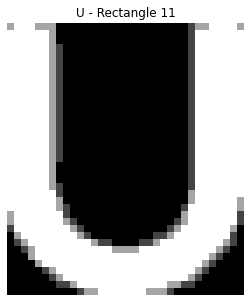

Hu Moments for U - Rectangle 11:
[ 5.78324838e-01  3.33945451e-03  2.12467568e-02  7.20486622e-03
 -8.24820649e-05 -4.11178395e-04 -3.38098916e-05]


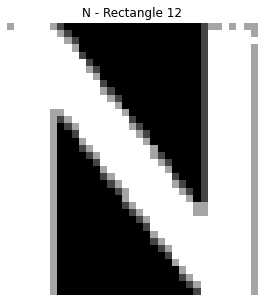

Hu Moments for N - Rectangle 12:
[ 4.26379650e-01  1.11065850e-02  1.01479512e-05  4.32171866e-06
 -8.13573927e-12  3.95556983e-07 -2.74395761e-11]


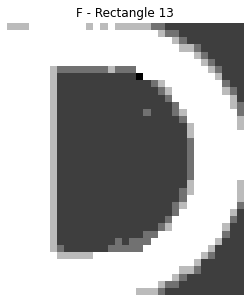

Hu Moments for F - Rectangle 13:
[ 1.65896371e-01  5.82620208e-04  3.30976551e-04  7.10950761e-06
 -3.43701328e-10 -1.70378070e-07 -2.83914291e-11]
Color to Grayscale Mapping:
Color: (172, 185, 215) -> Grayscale: 184.533
Color: (0, 0, 0) -> Grayscale: 0.0
Color: (97, 112, 156) -> Grayscale: 112.531
Color: (241, 175, 167) -> Grayscale: 193.822
Color: (251, 252, 252) -> Grayscale: 251.70099999999996
Color: (237, 52, 37) -> Grayscale: 105.605
Color: (33, 62, 138) -> Grayscale: 61.992999999999995
Color: (185, 69, 68) -> Grayscale: 103.57
Hu Moments Mapping:
U: [ 5.78324838e-01  3.33945451e-03  2.12467568e-02  7.20486622e-03
 -8.24820649e-05 -4.11178395e-04 -3.38098916e-05]
N: [ 4.26379650e-01  1.11065850e-02  1.01479512e-05  4.32171866e-06
 -8.13573927e-12  3.95556983e-07 -2.74395761e-11]
D: [ 1.66389620e-01  6.72843764e-04  3.45259469e-04  8.01678057e-06
 -4.20581831e-10 -2.07944176e-07  3.15988565e-11]
semispher1: [ 2.45545213e-01  3.10824286e-02  2.03408498e-03  1.60835657e-04
 -9.19934

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def reduce_colors(image, k):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))
    return result_image, center

def convert_to_grayscale(reduced_image, centers):
    grayscale_values = np.dot(centers, [0.299, 0.587, 0.114])
    color_to_gray = {tuple(color): gray for color, gray in zip(centers, grayscale_values)}
    grayscale_image = np.zeros((reduced_image.shape[0], reduced_image.shape[1]), dtype=np.uint8)
    for i in range(reduced_image.shape[0]):
        for j in range(reduced_image.shape[1]):
            pixel_color = tuple(reduced_image[i, j])
            grayscale_image[i, j] = color_to_gray[pixel_color]
    return grayscale_image, color_to_gray

def map_letters_to_hu_moments(image, contours, labels):
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
    hu_moments_map = {}
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        rect_img = image[y:y+h, x:x+w]
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments_map[labels[i]] = hu_moments
        plt.figure(figsize=(5, 5))
        plt.imshow(rect_img, cmap='gray')
        plt.title(f'{labels[i]} - Rectangle {i+1}')
        plt.axis('off')
        plt.show()
        print(f'Hu Moments for {labels[i]} - Rectangle {i+1}:')
        print(hu_moments)
    return hu_moments_map

image_path = 'template.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reduced_color_image, centers = reduce_colors(image_rgb, 8)
grayscale_image, color_to_gray_mapping = convert_to_grayscale(reduced_color_image, centers)
_, thresh = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(5, 5))
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_rectangles = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(reduced_color_image)
plt.title('Reduced Color Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_with_rectangles)
plt.title('Image with Rectangles')
plt.axis('off')
plt.show()

labels = ['U', 'N', 'D', 'semispher1', 'semispher2', 'E', 'R', 'G', 'R', 'O', 'U', 'N', 'F']
hu_moments_map = map_letters_to_hu_moments(grayscale_image, contours, labels)

print("Color to Grayscale Mapping:")
for color, gray in color_to_gray_mapping.items():
    print(f"Color: {color} -> Grayscale: {gray}")

print("Hu Moments Mapping:")
for label, hu_moments in hu_moments_map.items():
    print(f'{label}: {hu_moments}')

hu_moments_dict = {label: hu_moments.tolist() for label, hu_moments in hu_moments_map.items()}

print("Hu Moments Dictionary:")
print(hu_moments_dict)


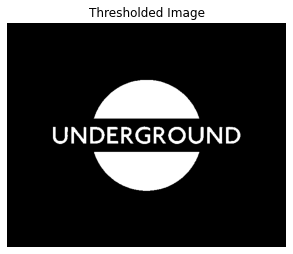

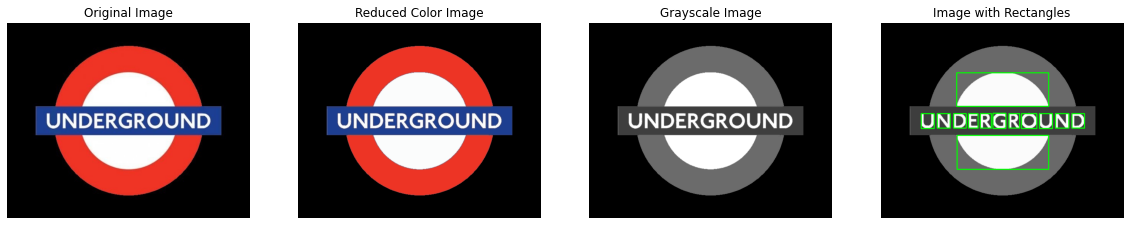

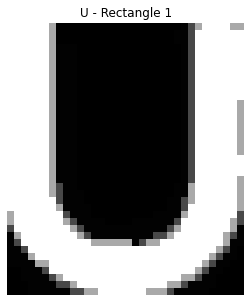

Hu Moments for U - Rectangle 1:
[ 5.85900853e-01  1.65807769e-03  2.18415789e-02  8.62367193e-03
 -1.18330411e-04 -3.14768589e-04 -2.32728289e-06]


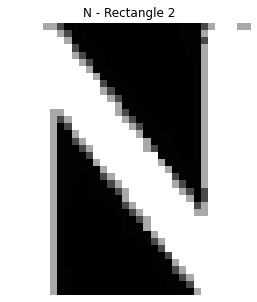

Hu Moments for N - Rectangle 2:
[ 4.27328918e-01  1.12607444e-02  1.65195463e-06  4.04615682e-07
  2.93409114e-14 -2.65916114e-08  3.29494390e-13]


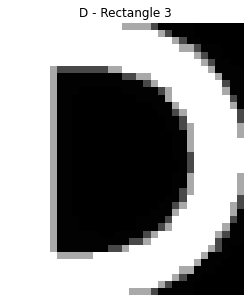

Hu Moments for D - Rectangle 3:
[ 1.66383830e-01  6.73368979e-04  3.46926572e-04  8.02541856e-06
 -4.23403630e-10 -2.08176692e-07  7.36781162e-12]


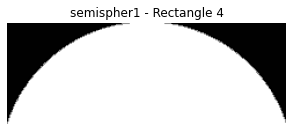

Hu Moments for semispher1 - Rectangle 4:
[ 2.45654362e-01  3.11306336e-02  2.04005201e-03  1.61241220e-04
 -9.24746037e-08 -2.84486385e-05 -6.94643625e-10]


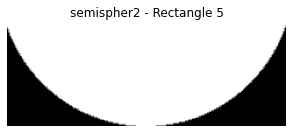

Hu Moments for semispher2 - Rectangle 5:
[ 2.44915010e-01  3.07796252e-02  2.02535658e-03  1.59692472e-04
 -9.07980580e-08 -2.80129173e-05  1.95702444e-09]


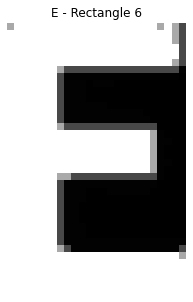

Hu Moments for E - Rectangle 6:
[ 4.23413600e-01  5.57940734e-02  3.93819672e-03  1.80485308e-03
 -3.76329610e-06 -3.99377946e-04  2.99857289e-06]


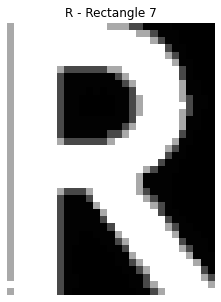

Hu Moments for R - Rectangle 7:
[ 2.39482460e-01  8.05984810e-03  7.52119069e-05  1.34725820e-03
 -7.50236617e-08  1.19251428e-04 -4.22250814e-07]


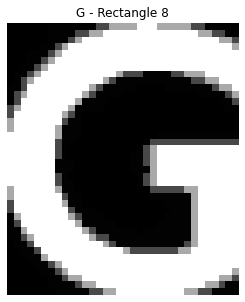

Hu Moments for G - Rectangle 8:
[ 4.88672658e-01  6.81849128e-03  5.53238270e-03  6.54859080e-04
 -4.94967100e-07 -4.30864886e-05 -1.14396976e-06]


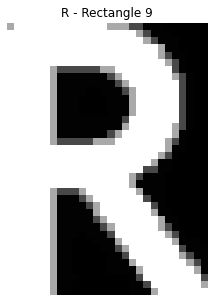

Hu Moments for R - Rectangle 9:
[ 2.37569275e-01  7.27715507e-03  8.81833169e-05  1.35630052e-03
 -2.35804043e-08  1.14194590e-04 -4.68465517e-07]


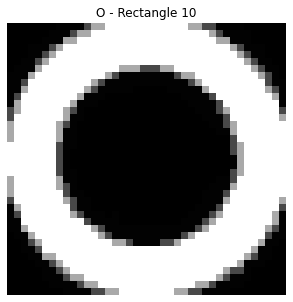

Hu Moments for O - Rectangle 10:
[1.59270302e-01 1.16160355e-05 7.09637081e-08 2.65123989e-11
 1.05960074e-20 7.31255241e-14 3.47877445e-20]


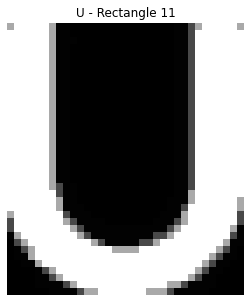

Hu Moments for U - Rectangle 11:
[ 5.78448624e-01  2.90255424e-03  2.05330847e-02  7.08399336e-03
 -7.83559173e-05 -3.77043067e-04 -3.40554693e-05]


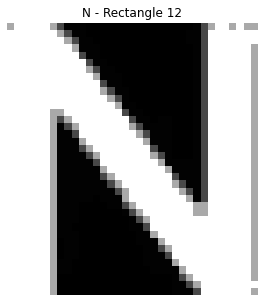

Hu Moments for N - Rectangle 12:
[4.26818935e-01 1.07594896e-02 8.05968502e-07 4.46533897e-06
 1.31585835e-12 4.38616219e-07 8.36829380e-12]


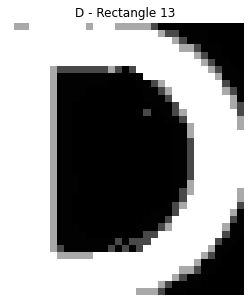

Hu Moments for D - Rectangle 13:
[ 1.65945392e-01  5.81261853e-04  3.39752838e-04  7.27084238e-06
 -3.60827950e-10 -1.74742078e-07 -1.98847680e-11]
Color to Grayscale Mapping:
Color: (191, 183, 202) -> Grayscale: 187.55799999999996
Color: (237, 52, 37) -> Grayscale: 105.605
Color: (100, 115, 158) -> Grayscale: 115.417
Color: (0, 0, 0) -> Grayscale: 0.0
Color: (29, 62, 144) -> Grayscale: 61.480999999999995
Color: (186, 70, 69) -> Grayscale: 104.57
Color: (251, 252, 252) -> Grayscale: 251.70099999999996
Color: (45, 62, 123) -> Grayscale: 63.870999999999995
Hu Moments Mapping:
U: [ 5.78448624e-01  2.90255424e-03  2.05330847e-02  7.08399336e-03
 -7.83559173e-05 -3.77043067e-04 -3.40554693e-05]
N: [4.26818935e-01 1.07594896e-02 8.05968502e-07 4.46533897e-06
 1.31585835e-12 4.38616219e-07 8.36829380e-12]
D: [ 1.65945392e-01  5.81261853e-04  3.39752838e-04  7.27084238e-06
 -3.60827950e-10 -1.74742078e-07 -1.98847680e-11]
semispher1: [ 2.45654362e-01  3.11306336e-02  2.04005201e-03  1.61241220

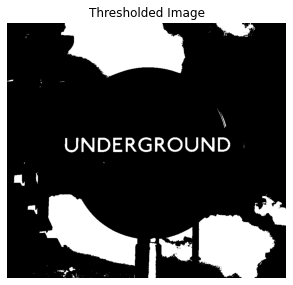

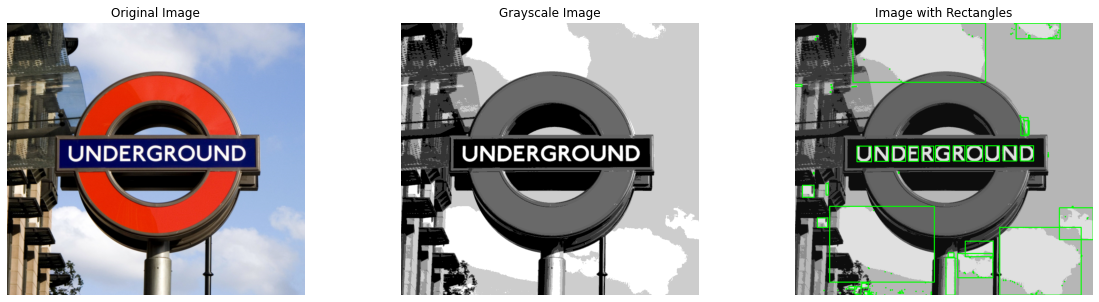

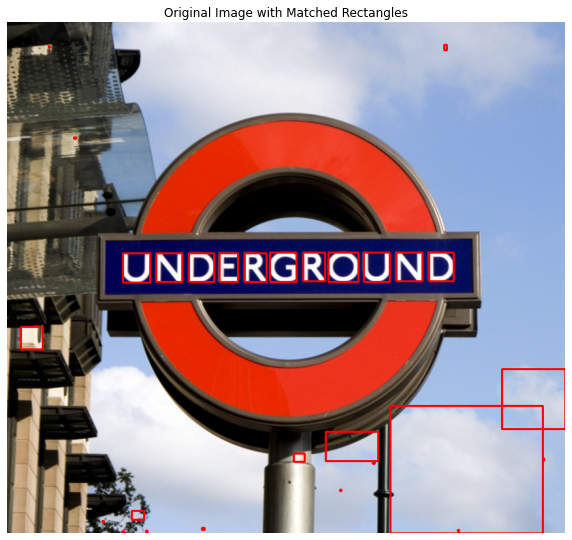

Hu Moments Count in New Image:
U: 3
N: 2
D: 8
semispher1: 8
semispher2: 2
E: 3
R: 11
G: 0
O: 1


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def reduce_colors(image, k):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))
    return result_image, center

def convert_to_grayscale(reduced_image, centers):
    grayscale_values = np.dot(centers, [0.299, 0.587, 0.114])
    color_to_gray = {tuple(color): gray for color, gray in zip(centers, grayscale_values)}
    grayscale_image = np.zeros((reduced_image.shape[0], reduced_image.shape[1]), dtype=np.uint8)
    for i in range(reduced_image.shape[0]):
        for j in range(reduced_image.shape[1]):
            pixel_color = tuple(reduced_image[i, j])
            grayscale_image[i, j] = color_to_gray[pixel_color]
    return grayscale_image, color_to_gray

def map_letters_to_hu_moments(image, contours, labels):
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
    hu_moments_map = {}
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        rect_img = image[y:y+h, x:x+w]
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments_map[labels[i]] = hu_moments
        plt.figure(figsize=(5, 5))
        plt.imshow(rect_img, cmap='gray')
        plt.title(f'{labels[i]} - Rectangle {i+1}')
        plt.axis('off')
        plt.show()
        print(f'Hu Moments for {labels[i]} - Rectangle {i+1}:')
        print(hu_moments)
    return hu_moments_map

def detect_and_match_hu_moments(image_path, known_hu_moments):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    reduced_color_image, centers = reduce_colors(image_rgb, 8)
    grayscale_image, _ = convert_to_grayscale(reduced_color_image, centers)
    _, thresh = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(5, 5))
    plt.imshow(thresh, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_rectangles = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_with_rectangles)
    plt.title('Image with Rectangles')
    plt.axis('off')
    plt.show()

    hu_moments_count = {label: 0 for label in known_hu_moments.keys()}
    all_rectangles = []

    for contour in contours:
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()
        closest_label = None
        min_distance = float('inf')
        
        for label, known_hu in known_hu_moments.items():
            distance = np.linalg.norm(hu_moments - known_hu)
            if distance < min_distance:
                min_distance = distance
                closest_label = label
        
        if closest_label and min_distance < 1e-1:  # Adjusted threshold for flexibility
            hu_moments_count[closest_label] += 1
            x, y, w, h = cv2.boundingRect(contour)
            all_rectangles.append((x, y, w, h))
            if closest_label not in ['semispher1', 'semispher2']:  # Exclude semispheres
                cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title('Original Image with Matched Rectangles')
    plt.axis('off')
    plt.show()

    return hu_moments_count

# Initial template image
template_image_path = 'template.jpg'
image = cv2.imread(template_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reduced_color_image, centers = reduce_colors(image_rgb, 8)
grayscale_image, color_to_gray_mapping = convert_to_grayscale(reduced_color_image, centers)
_, thresh = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(5, 5))
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_rectangles = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(reduced_color_image)
plt.title('Reduced Color Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_with_rectangles)
plt.title('Image with Rectangles')
plt.axis('off')
plt.show()

labels = ['U', 'N', 'D', 'semispher1', 'semispher2', 'E', 'R', 'G', 'R', 'O', 'U', 'N', 'D']
known_hu_moments = map_letters_to_hu_moments(grayscale_image, contours, labels)

print("Color to Grayscale Mapping:")
for color, gray in color_to_gray_mapping.items():
    print(f"Color: {color} -> Grayscale: {gray}")

print("Hu Moments Mapping:")
for label, hu_moments in known_hu_moments.items():
    print(f'{label}: {hu_moments}')

hu_moments_dict = {label: hu_moments.tolist() for label, hu_moments in known_hu_moments.items()}
print("Hu Moments Dictionary:")
print(hu_moments_dict)

# New image to be tested
test_image_path = 'image_test_1.jpg'
hu_moments_count = detect_and_match_hu_moments(test_image_path, known_hu_moments)

print("Hu Moments Count in New Image:")
for label, count in hu_moments_count.items():
    print(f'{label}: {count}')
